# MACD  BTC和EOS通用
用MACD策略，判断上涨趋势：1）MACD前两个时间段上涨，切上涨幅度大于一定阈值；2）DIFF大于零；3）成交量连续两个交易周期均上涨。以上3个条件可以较为准确的判断上涨趋势，下跌趋势对应修改判断方向即可。加入仓位管理增加稳定性。

20180601-20181127  
Sharpe Ratio：3.05  
总收益率：70.25%  
年化收益：93.66%  
百分比最大回撤: -7.42%  

20180110-20181127  
Sharpe Ratio：1.72  
总收益率：179.09%  
年化收益：133.48%  
百分比最大回撤: -22.36%  

## 配置引擎参数

In [1]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 00:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181127 23:59') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

In [2]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MACDStrategy(CtaTemplate):
    """MACD策略"""
    className = 'MACDStrategy'
    author = 'xiaotao'
    
    # 策略参数
    fastPeriod = 12     # 收盘价快速均线参数
    slowPeriod = 26    # 收盘价慢速均线参数
    M = 9
    lot = 100             # 设置手数
        
    fastPeriod_v = 2    #成交量快速均线参数
    slowPeriod_v = 4    #成交量慢速均线参数
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['fastPeriod',
                 'slowPeriod']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        if not am60.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am60.close, self.fastPeriod)
        slowMa = ta.EMA(am60.close, self.slowPeriod)
        diff = fastMa - slowMa
        dea = ta.EMA(diff,self.M)
        MACD = 2*(diff - dea)
        diff_MACD_1 = (MACD[-1]-MACD[-2])/MACD[-2]
        diff_MACD_2 = (MACD[-5]-MACD[-6])/MACD[-6]
        
        fastMa_v = ta.EMA(am60.volume, self.fastPeriod_v)
        slowMa_v = ta.EMA(am60.volume, self.slowPeriod_v)
        
        crossOver = (diff[-1]>0) and (diff_MACD_1>0.2) and (diff_MACD_2>0.1) and (fastMa_v[-1]>slowMa_v[-1]) and (fastMa_v[-2]>slowMa_v[-2])
        crossBelow = (diff[-1]<0) and (diff_MACD_1<-0.23) and (fastMa_v[-1]<slowMa_v[-1]) and (fastMa_v[-2]<slowMa_v[-2])

        
        # 构建进出场逻辑-------------------------------------------------
        # 如果金叉时手头没有多头持仓
        if (crossOver) and (self.posDict[symbol+'_LONG']==0):
            # 如果没有空头持仓，则直接做多
            if  self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        # 如果金叉时手头没有空头持仓
        elif (crossBelow) and (self.posDict[symbol+'_SHORT']==0):
            if self.posDict[symbol+'_LONG']==0:
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [3]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(MACDStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_60Min_bar函数functools.partial(<function MACDStrategy.on60MinBar at 0x0000023AEA33E598>, <__main__.MACDStrategy object at 0x0000023AEA45B710>)
2018-12-20 20:00:33.530216	开始回测
2018-12-20 20:00:33.530216	策略初始化
2018-12-20 20:00:33.532210	载入历史数据。数据范围:[20180523 16:00,20180601 00:00)
2018-12-20 20:00:35.735378	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-20 20:00:35.737371	载入完成，数据量：12000
2018-12-20 20:00:35.738369	策略初始化完成
2018-12-20 20:00:35.738369	策略启动完成
2018-12-20 20:00:35.738369	开始回放回测数据,回测范围:[20180601 00:00,20181127 23:59)
2018-12-20 20:00:35.761336	载入历史数据。数据范围:[20180601 00:00,20181127 23:59)
2018-12-20 20:00:49.336746	 当前品种 BTCUSDT:binance 的数据，全部来自于本地缓存
2018-12-20 20:00:49.392622	载入完成，数据量：257407
2018-12-20 20:00:49.393593	当前回放数据:[20180601 00:00,20181127 23:59)
[INFO] 品种BTCUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180601000000
2018-12-20 20:00:49.394589	载入历史数据。数据范围:[20180531 08:51,20180603 00:01

In [4]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-06-02 04:00:00,空,,,0.0,,开仓,1,,7440.14,0.0,None,,,1,2018-06-02 04:00:00,100,1,BTCUSDT:binance,1
2018-06-26 22:00:00,多,,,0.0,,平仓,2,,6170.03,0.0,None,,,2,2018-06-26 22:00:00,100,2,BTCUSDT:binance,2
2018-06-26 22:00:00,多,,,0.0,,开仓,3,,6170.03,0.0,None,,,3,2018-06-26 22:00:00,100,3,BTCUSDT:binance,3
2018-06-28 16:00:00,空,,,0.0,,平仓,4,,6116.75,0.0,None,,,4,2018-06-28 16:00:00,100,4,BTCUSDT:binance,4
2018-06-28 16:00:00,空,,,0.0,,开仓,5,,6116.75,0.0,None,,,5,2018-06-28 16:00:00,100,5,BTCUSDT:binance,5
2018-06-30 10:00:00,多,,,0.0,,平仓,6,,6411.99,0.0,None,,,6,2018-06-30 10:00:00,100,6,BTCUSDT:binance,6
2018-06-30 10:00:00,多,,,0.0,,开仓,7,,6411.99,0.0,None,,,7,2018-06-30 10:00:00,100,7,BTCUSDT:binance,7
2018-07-06 07:00:00,空,,,0.0,,平仓,8,,6537.80,0.0,None,,,8,2018-07-06 07:00:00,100,8,BTCUSDT:binance,8
2018-07-06 07:00:00,空,,,0.0,,开仓,9,,6537.80,0.0,None,,,9,2018-07-06 07:00:00,100,9,BTCUSDT:binance,9


## 查看绩效回测绩效

2018-12-20 20:01:05.042859	计算按日统计结果
2018-12-20 20:01:05.094850	------------------------------
2018-12-20 20:01:05.094850	首个交易日：	2018-06-01 00:00:00
2018-12-20 20:01:05.094850	最后交易日：	2018-11-27 00:00:00
2018-12-20 20:01:05.094850	总交易日：	180
2018-12-20 20:01:05.094850	盈利交易日	107
2018-12-20 20:01:05.094850	亏损交易日：	71
2018-12-20 20:01:05.094850	起始资金：	1000000
2018-12-20 20:01:05.094850	结束资金：	1,702,464.68
2018-12-20 20:01:05.094850	总收益率：	70.25%
2018-12-20 20:01:05.094850	年化收益：	93.66%
2018-12-20 20:01:05.094850	总盈亏：	702,464.68
2018-12-20 20:01:05.094850	最大回撤: 	-86,565.08
2018-12-20 20:01:05.094850	百分比最大回撤: -7.42%
2018-12-20 20:01:05.094850	总手续费：	24,454.72
2018-12-20 20:01:05.094850	总滑点：	14.6
2018-12-20 20:01:05.094850	总成交金额：	48,909,444.0
2018-12-20 20:01:05.094850	总成交笔数：	73
2018-12-20 20:01:05.094850	日均盈亏：	3,902.58
2018-12-20 20:01:05.094850	日均手续费：	135.86
2018-12-20 20:01:05.094850	日均滑点：	0.08
2018-12-20 20:01:05.094850	日均成交金额：	271,719.13
2018-12-20 20:01:05.094850	日均成交笔数：	0.41
2018-12-20 20:01:0

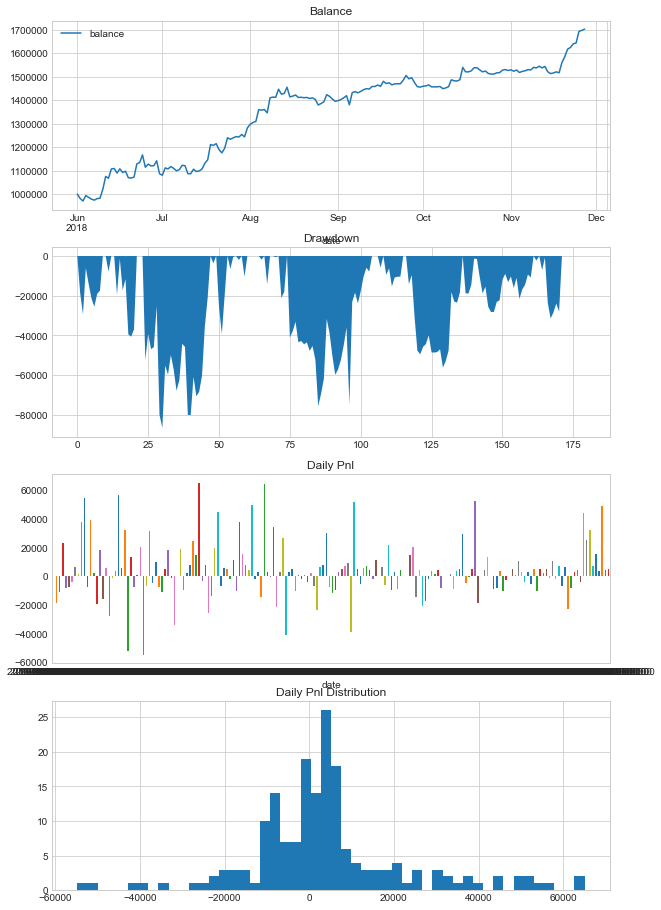

In [5]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-20 20:01:07.680355	计算回测结果
2018-12-20 20:01:07.684345	------------------------------
2018-12-20 20:01:07.684345	第一笔交易：	2018-06-26 22:00:00
2018-12-20 20:01:07.684345	最后一笔交易：	2018-11-27 23:57:00
2018-12-20 20:01:07.684345	总交易次数：	37
2018-12-20 20:01:07.685342	总盈亏：	702,275.43
2018-12-20 20:01:07.685342	最大回撤: 	-57,543.65
2018-12-20 20:01:07.685342	平均每笔盈利：	18,980.42
2018-12-20 20:01:07.685342	平均每笔滑点：	0.4
2018-12-20 20:01:07.685342	平均每笔佣金：	666.05
2018-12-20 20:01:07.685342	胜率		54.05%
2018-12-20 20:01:07.685342	盈利交易平均值	47,236.73
2018-12-20 20:01:07.685342	亏损交易平均值	-14,262.31
2018-12-20 20:01:07.685342	盈亏比：	3.31


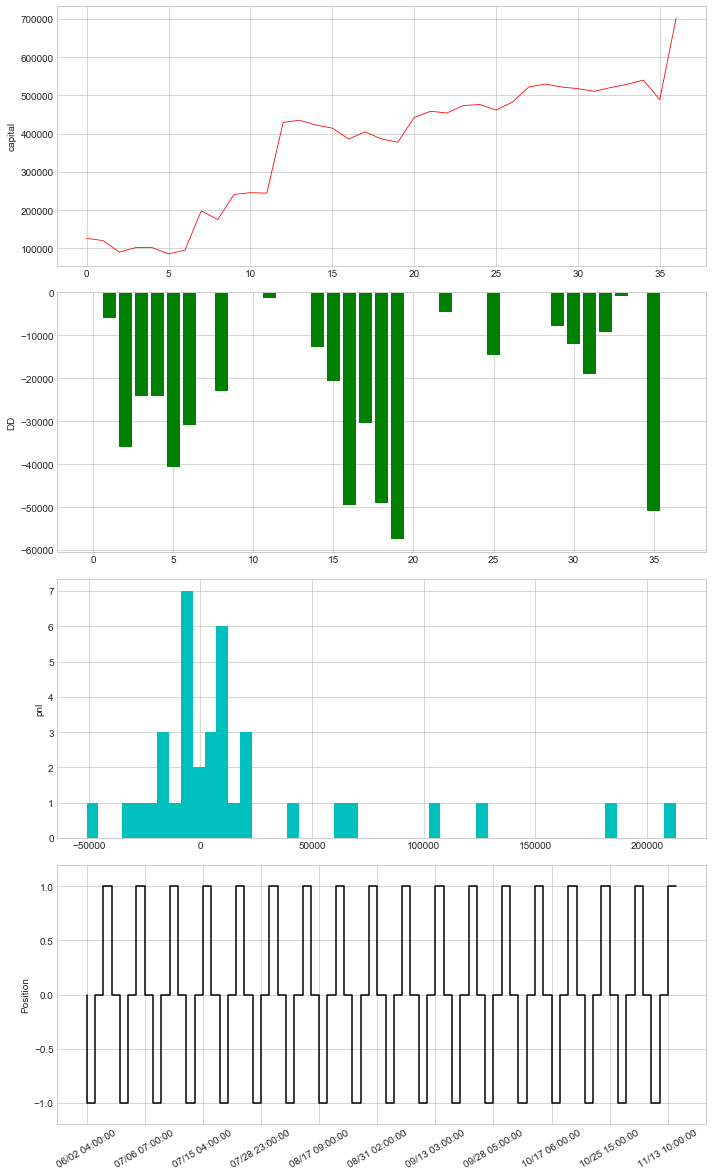

In [6]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [7]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)

2018-12-20 20:01:08.483208	计算按日统计结果


In [8]:
print(pd.Series(result)) # 显示绩效指标

startDate           2018-06-01 00:00:00
endDate             2018-11-27 00:00:00
totalDays                           180
profitDays                          107
lossDays                             71
endBalance                  1.70246e+06
maxDrawdown                    -86565.1
maxDdPercent                   -7.41813
totalNetPnl                      702465
dailyNetPnl                     3902.58
totalCommission                 24454.7
dailyCommission                  135.86
totalSlippage                      14.6
dailySlippage                 0.0811111
totalTurnover               4.89094e+07
dailyTurnover                    271719
totalTradeCount                      73
dailyTradeCount                0.405556
totalReturn                     70.2465
annualizedReturn                 93.662
dailyReturn                    0.295598
returnStd                       1.50281
sharpeRatio                     3.04722
dtype: object


#下面对EOS品种进行检测
对策略做了参数调整：
1）手数由适用BTC的100改为20000
2）diff_MACD_2的滚动周期，还有阈值。

In [9]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180611 00:00',initHours=20) # 设置回测用的数据起始日期
engine.setEndDate('20181127 23:59') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(1000000)  # 设置回测本金

In [10]:
from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MACDStrategy(CtaTemplate):
    """MACD策略"""
    className = 'MACDStrategy'
    author = 'xiaotao'
    
    # 策略参数
    fastPeriod = 12     # 收盘价快速均线参数
    slowPeriod = 26    # 收盘价慢速均线参数
    M = 9
    lot = 20000             # 设置手数
        
    fastPeriod_v = 2    #成交量快速均线参数
    slowPeriod_v = 4    #成交量慢速均线参数
    
    # 策略变量
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['fastPeriod',
                 'slowPeriod']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        am60 = self.getArrayManager(symbol, "60m") # 获取历史数组
        if not am60.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am60.close, self.fastPeriod)
        slowMa = ta.EMA(am60.close, self.slowPeriod)
        diff = fastMa - slowMa
        dea = ta.EMA(diff,self.M)
        MACD = 2*(diff - dea)
        diff_MACD_1 = (MACD[-1]-MACD[-2])/MACD[-2]
        diff_MACD_2 = (MACD[-3]-MACD[-4])/MACD[-4]
        
        fastMa_v = ta.EMA(am60.volume, self.fastPeriod_v)
        slowMa_v = ta.EMA(am60.volume, self.slowPeriod_v)
        
        crossOver = (diff[-1]>0) and (diff_MACD_1>0.12) and (diff_MACD_2>0) and (fastMa_v[-1]>slowMa_v[-1]) and (fastMa_v[-2]>slowMa_v[-2])
        crossBelow = (diff[-1]<0) and (diff_MACD_1<-0.22) and (diff_MACD_2<0) and (fastMa_v[-1]<slowMa_v[-1]) and (fastMa_v[-2]<slowMa_v[-2])

        
        # 构建进出场逻辑-------------------------------------------------
        # 如果金叉时手头没有多头持仓
        if (crossOver) and (self.posDict[symbol+'_LONG']==0):
            # 如果没有空头持仓，则直接做多
            if  self.posDict[symbol+'_SHORT']==0:
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
        # 如果金叉时手头没有空头持仓
        elif (crossBelow) and (self.posDict[symbol+'_SHORT']==0):
            if self.posDict[symbol+'_LONG']==0:
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [11]:
# 在引擎中创建策略对象
parameterDict = {'symbolList':['EOSUSDT:binance']} # 策略参数配置
engine.initStrategy(MACDStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_60Min_bar函数functools.partial(<function MACDStrategy.on60MinBar at 0x0000023AFBF33730>, <__main__.MACDStrategy object at 0x0000023AFBF39A20>)
2018-12-20 20:01:08.581945	开始回测
2018-12-20 20:01:08.581945	策略初始化
2018-12-20 20:01:08.582941	载入历史数据。数据范围:[20180610 04:00,20180611 00:00)
2018-12-20 20:01:08.670739	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-20 20:01:08.671708	载入完成，数据量：1200
2018-12-20 20:01:08.671708	策略初始化完成
2018-12-20 20:01:08.671708	策略启动完成
2018-12-20 20:01:08.671708	开始回放回测数据,回测范围:[20180611 00:00,20181127 23:59)
2018-12-20 20:01:08.696636	载入历史数据。数据范围:[20180611 00:00,20181127 23:59)
2018-12-20 20:01:24.037129	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-20 20:01:24.110933	载入完成，数据量：243007
2018-12-20 20:01:24.110933	当前回放数据:[20180611 00:00,20181127 23:59)
[INFO] 品种EOSUSDT:binance开始生成未完成的1mK线数据,时间起点为:20180611000000
2018-12-20 20:01:24.112928	载入历史数据。数据范围:[20180610 08:51,20180613 00:01)

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\vnpy_fxdayu-1.1.14-py3.6.egg\vnpy\trader\app\ctaStrategy\ctaBacktesting.py", line 282, in loadHistoryData
    dataList += [self.parseData(dataClass, item) for item in data_df[(data_df.datetime>=start) & (data_df.datetime<end)].to_dict("record")]
  File "C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py", line 4372, in __getattr__
    return object.__getattribute__(self, name)
AttributeError: 'DataFrame' object has no attribute 'datetime'


[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606200000 , 20180610230000]
[INFO] 品种EOSUSDT:binance开始生成1mK线数据,时间起点为:20180611000100
[INFO] 品种EOSUSDT:binance开始生成60mK线数据,时间起点为:20180611000000
[DEBUG] merged bar {'gatewayName': '', 'rawData': None, 'vtSymbol': 'EOSUSDT:binance', 'symbol': 'EOSUSDT', 'exchange': 'binance', 'open': 13.15, 'high': 13.1647, 'low': 12.922, 'close': 12.9499, 'date': '20180611', 'time': '00:00:00.000000', 'datetime': datetime.datetime(2018, 6, 11, 0, 0), 'volume': 385852.4499999997, 'openInterest': 0}
[INFO] 品种EOSUSDT:binance的历史60mK线更新，范围为:[20180606210000 , 20180611000000]
[INFO] 品种EOSUSDT:binance的60mK线准备就绪,当前K线时间为20180611000000
2018-12-20 20:01:36.894222	数据回放结束ss: 100%    


In [12]:
import pandas as pd
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeDf = tradeReport.set_index('dt')
tradeDf

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,price_avg,rawData,status,symbol,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
dt,,,,,,,,,,,,,,,,,,,
2018-06-11 11:00:00,空,,,0.0,,开仓,1,,11.5498,0.0,None,,,1,2018-06-11 11:00:00,20000,1,EOSUSDT:binance,1
2018-06-19 02:00:00,多,,,0.0,,平仓,2,,10.6808,0.0,None,,,2,2018-06-19 02:00:00,20000,2,EOSUSDT:binance,2
2018-06-19 02:00:00,多,,,0.0,,开仓,3,,10.6808,0.0,None,,,3,2018-06-19 02:00:00,20000,3,EOSUSDT:binance,3
2018-06-21 07:00:00,空,,,0.0,,平仓,4,,10.4072,0.0,None,,,4,2018-06-21 07:00:00,20000,4,EOSUSDT:binance,4
2018-06-21 07:00:00,空,,,0.0,,开仓,5,,10.4072,0.0,None,,,5,2018-06-21 07:00:00,20000,5,EOSUSDT:binance,5
2018-06-21 12:00:00,多,,,0.0,,平仓,6,,10.6779,0.0,None,,,6,2018-06-21 12:00:00,20000,6,EOSUSDT:binance,6
2018-06-21 12:00:00,多,,,0.0,,开仓,7,,10.6779,0.0,None,,,7,2018-06-21 12:00:00,20000,7,EOSUSDT:binance,7
2018-06-22 09:00:00,空,,,0.0,,平仓,8,,10.3916,0.0,None,,,8,2018-06-22 09:00:00,20000,8,EOSUSDT:binance,8
2018-06-22 09:00:00,空,,,0.0,,开仓,9,,10.3916,0.0,None,,,9,2018-06-22 09:00:00,20000,9,EOSUSDT:binance,9


2018-12-20 20:01:36.977190	计算按日统计结果
2018-12-20 20:01:37.014139	------------------------------
2018-12-20 20:01:37.014139	首个交易日：	2018-06-11 00:00:00
2018-12-20 20:01:37.014139	最后交易日：	2018-11-27 00:00:00
2018-12-20 20:01:37.014139	总交易日：	170
2018-12-20 20:01:37.014139	盈利交易日	94
2018-12-20 20:01:37.014139	亏损交易日：	76
2018-12-20 20:01:37.014139	起始资金：	1000000
2018-12-20 20:01:37.014139	结束资金：	1,271,102.72
2018-12-20 20:01:37.014139	总收益率：	27.11%
2018-12-20 20:01:37.014139	年化收益：	38.27%
2018-12-20 20:01:37.014139	总盈亏：	271,102.72
2018-12-20 20:01:37.014139	最大回撤: 	-38,805.32
2018-12-20 20:01:37.014139	百分比最大回撤: -3.73%
2018-12-20 20:01:37.014139	总手续费：	6,343.28
2018-12-20 20:01:37.014139	总滑点：	3,880.0
2018-12-20 20:01:37.014139	总成交金额：	12,686,552.0
2018-12-20 20:01:37.014139	总成交笔数：	97
2018-12-20 20:01:37.014139	日均盈亏：	1,594.72
2018-12-20 20:01:37.014139	日均手续费：	37.31
2018-12-20 20:01:37.014139	日均滑点：	22.82
2018-12-20 20:01:37.015087	日均成交金额：	74,626.78
2018-12-20 20:01:37.015087	日均成交笔数：	0.57
2018-12-20 20:01:3

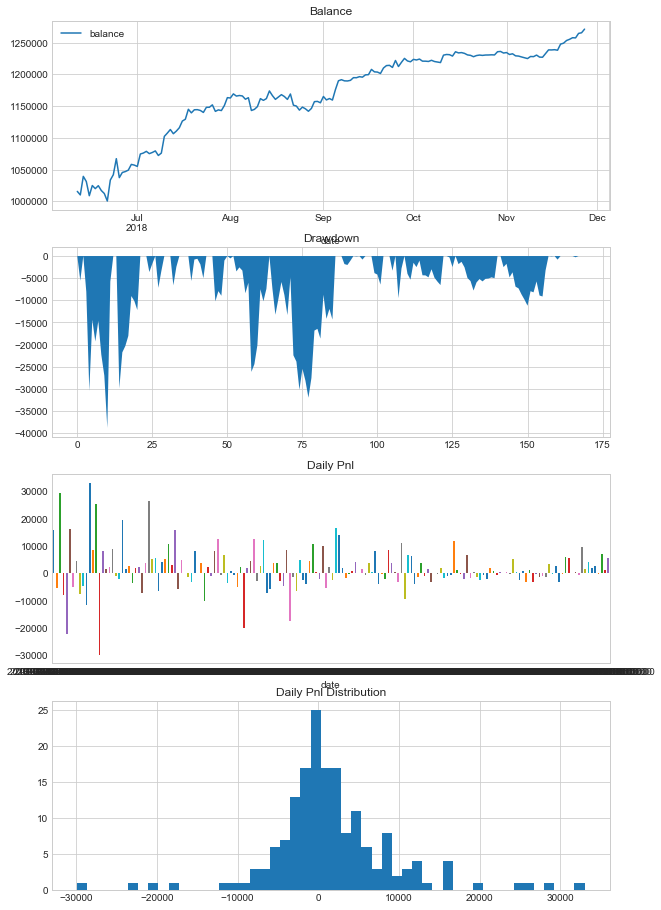

In [13]:
# 显示逐日回测结果
engine.showDailyResult()


2018-12-20 20:01:39.337876	计算回测结果
2018-12-20 20:01:39.342862	------------------------------
2018-12-20 20:01:39.342862	第一笔交易：	2018-06-19 02:00:00
2018-12-20 20:01:39.342862	最后一笔交易：	2018-11-27 23:57:00
2018-12-20 20:01:39.342862	总交易次数：	49
2018-12-20 20:01:39.342862	总盈亏：	271,033.14
2018-12-20 20:01:39.342862	最大回撤: 	-27,599.61
2018-12-20 20:01:39.342862	平均每笔盈利：	5,531.29
2018-12-20 20:01:39.342862	平均每笔滑点：	80.0
2018-12-20 20:01:39.342862	平均每笔佣金：	130.06
2018-12-20 20:01:39.342862	胜率		53.06%
2018-12-20 20:01:39.342862	盈利交易平均值	14,062.05
2018-12-20 20:01:39.342862	亏损交易平均值	-4,112.18
2018-12-20 20:01:39.342862	盈亏比：	3.42


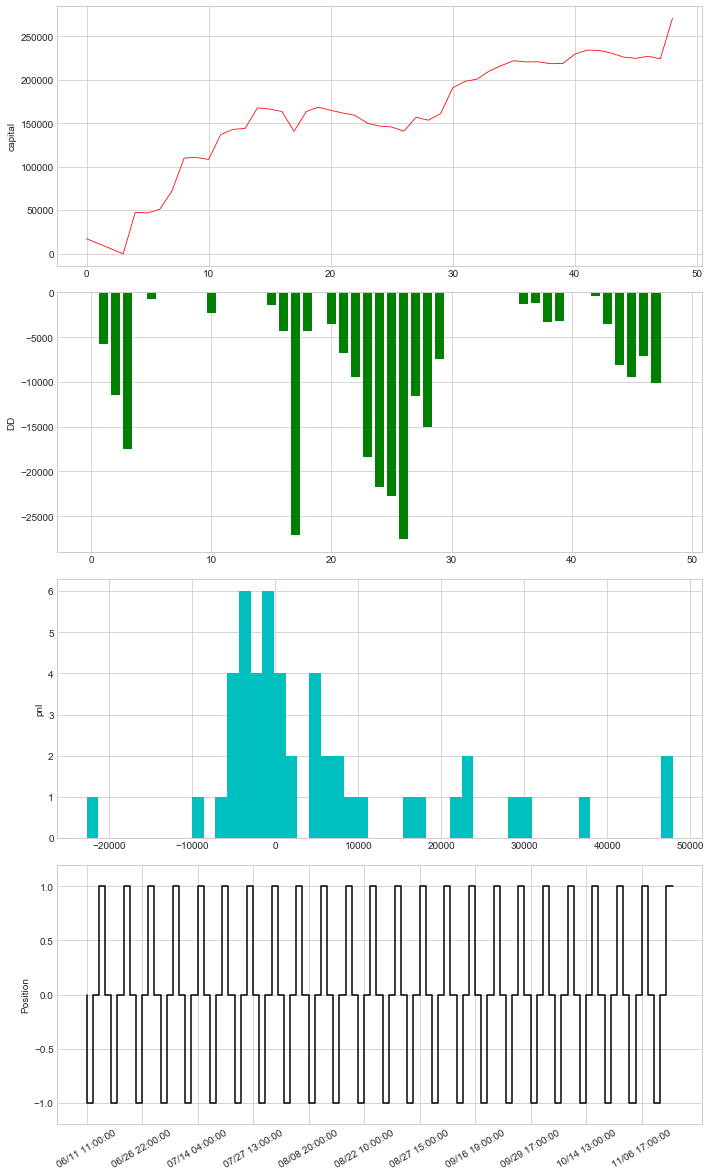

In [14]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [15]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)

2018-12-20 20:01:40.039016	计算按日统计结果
